# Results

## Pair dispersion

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
scripts_path = os.path.join(os.path.dirname(os.getcwd()), 'scripts')
sys.path.append(scripts_path)
from functions_pair_dispersion import get_trajectory, create_trajectories_and_times_list, create_mask_trajectories_optimized, temporal_interpolation, distance_pair, K_pair, apply_mask_KD, calculate_pair_separation_pair_diffusivity_and_mask_pair
import pandas as pd

from datetime import date
import os
from matplotlib.lines import Line2D
import cmocean.cm as cmo

import jax
import jax.numpy as jnp
from jaxtyping import Array, Float, Int, Real
import xarray as xr


from pastax.trajectory import Trajectory

In [95]:
# Figure styling
from matplotlib import rc
import matplotlib as mpl

rc('lines',  markersize=10)
rc("legend", fontsize=20)
rc("axes", labelsize=20)
rc("xtick", labelsize=20)
rc("ytick", labelsize=20)
rc("lines", linewidth=1.5)

mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']+ mpl.rcParams['font.serif']
mpl.rcParams["mathtext.fontset"] = "stix"
#mpl.rcParams['text.usetex'] = True

cmap = plt.colormaps["ocean"]
cmap = cmo.speed

In [96]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_disable_jit", False)

In [97]:
base_dir = "../data/drifters"
l2_dir = f"{base_dir}/l2"


spot_l2_df = pd.read_parquet(os.path.join(l2_dir, "spot_l2_df.parquet"))

spot_l2_df['deploy_date'] = pd.to_datetime(spot_l2_df['deploy_time']).dt.date

date_deployment_1 = date(2025, 5, 12)
date_deployment_2 = date(2025, 5, 18)
date_deployment_3 = date(2025, 5, 24)
date_deployment_4 = date(2025, 5, 30)

drifters_deployment_1 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_1]['drifter_id'].unique()
drifters_deployment_2 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_2]['drifter_id'].unique()
drifters_deployment_3 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_3]['drifter_id'].unique()
drifters_deployment_4 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_4]['drifter_id'].unique()


def create_trajectories_and_times_list(drifters_id, spot_l2_df):
    traj_list = []
    for i in range(len(drifters_id)):
        drifter_id = drifters_id[i]
        df = spot_l2_df[spot_l2_df["drifter_id"] == drifter_id]

        traj = Trajectory.from_array(
            jnp.stack((jnp.asarray(df['lat']), jnp.asarray(df['lon'])), axis=-1), 
            jnp.asarray(np.asarray(df['time']).astype("datetime64[s]").astype(int)))
        traj_list.append(traj)

    traj_times = []
    for traj in traj_list:
        traj_times.append(np.asarray(traj.times.value).astype("datetime64[s]"))
    return traj_list, traj_times

traj_list_1, traj_times_1 = create_trajectories_and_times_list(drifters_deployment_1, spot_l2_df)
traj_list_2, traj_times_2 = create_trajectories_and_times_list(drifters_deployment_2, spot_l2_df)
traj_list_3, traj_times_3 = create_trajectories_and_times_list(drifters_deployment_3, spot_l2_df)
traj_list_4, traj_times_4 = create_trajectories_and_times_list(drifters_deployment_4, spot_l2_df)



dt = 30*60 # in seconds
ts_1 = np.arange(date_deployment_1, np.datetime64('now'), np.timedelta64(30,'m'))
ts_2 = np.arange(date_deployment_2, np.datetime64('now'), np.timedelta64(30,'m'))
ts_3 = np.arange(date_deployment_3, np.datetime64('now'), np.timedelta64(30,'m'))
ts_4 = np.arange(date_deployment_4, np.datetime64('now'), np.timedelta64(30,'m'))

masks_time_1 = create_mask_trajectories_optimized(traj_list_1, traj_times_1, ts_1)
masks_time_2 = create_mask_trajectories_optimized(traj_list_2, traj_times_2, ts_2)
masks_time_3 = create_mask_trajectories_optimized(traj_list_3, traj_times_3, ts_3)
masks_time_4 = create_mask_trajectories_optimized(traj_list_4, traj_times_4, ts_4)

interpolated_trajs_1 = temporal_interpolation(traj_list_1, masks_time_1, ts_1, traj_times_1)
interpolated_trajs_2 = temporal_interpolation(traj_list_2, masks_time_2, ts_2, traj_times_2)
interpolated_trajs_3 = temporal_interpolation(traj_list_3, masks_time_3, ts_3, traj_times_3)
interpolated_trajs_4 = temporal_interpolation(traj_list_4, masks_time_4, ts_4, traj_times_4)

Ds_1, Ks_1, mask_pair_1 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_1, masks_time_1, dt)
Ds_2, Ks_2, mask_pair_2 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_2, masks_time_2, dt)
Ds_3, Ks_3, mask_pair_3 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_3, masks_time_3, dt)
Ds_4, Ks_4, mask_pair_4 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_4, masks_time_4, dt)


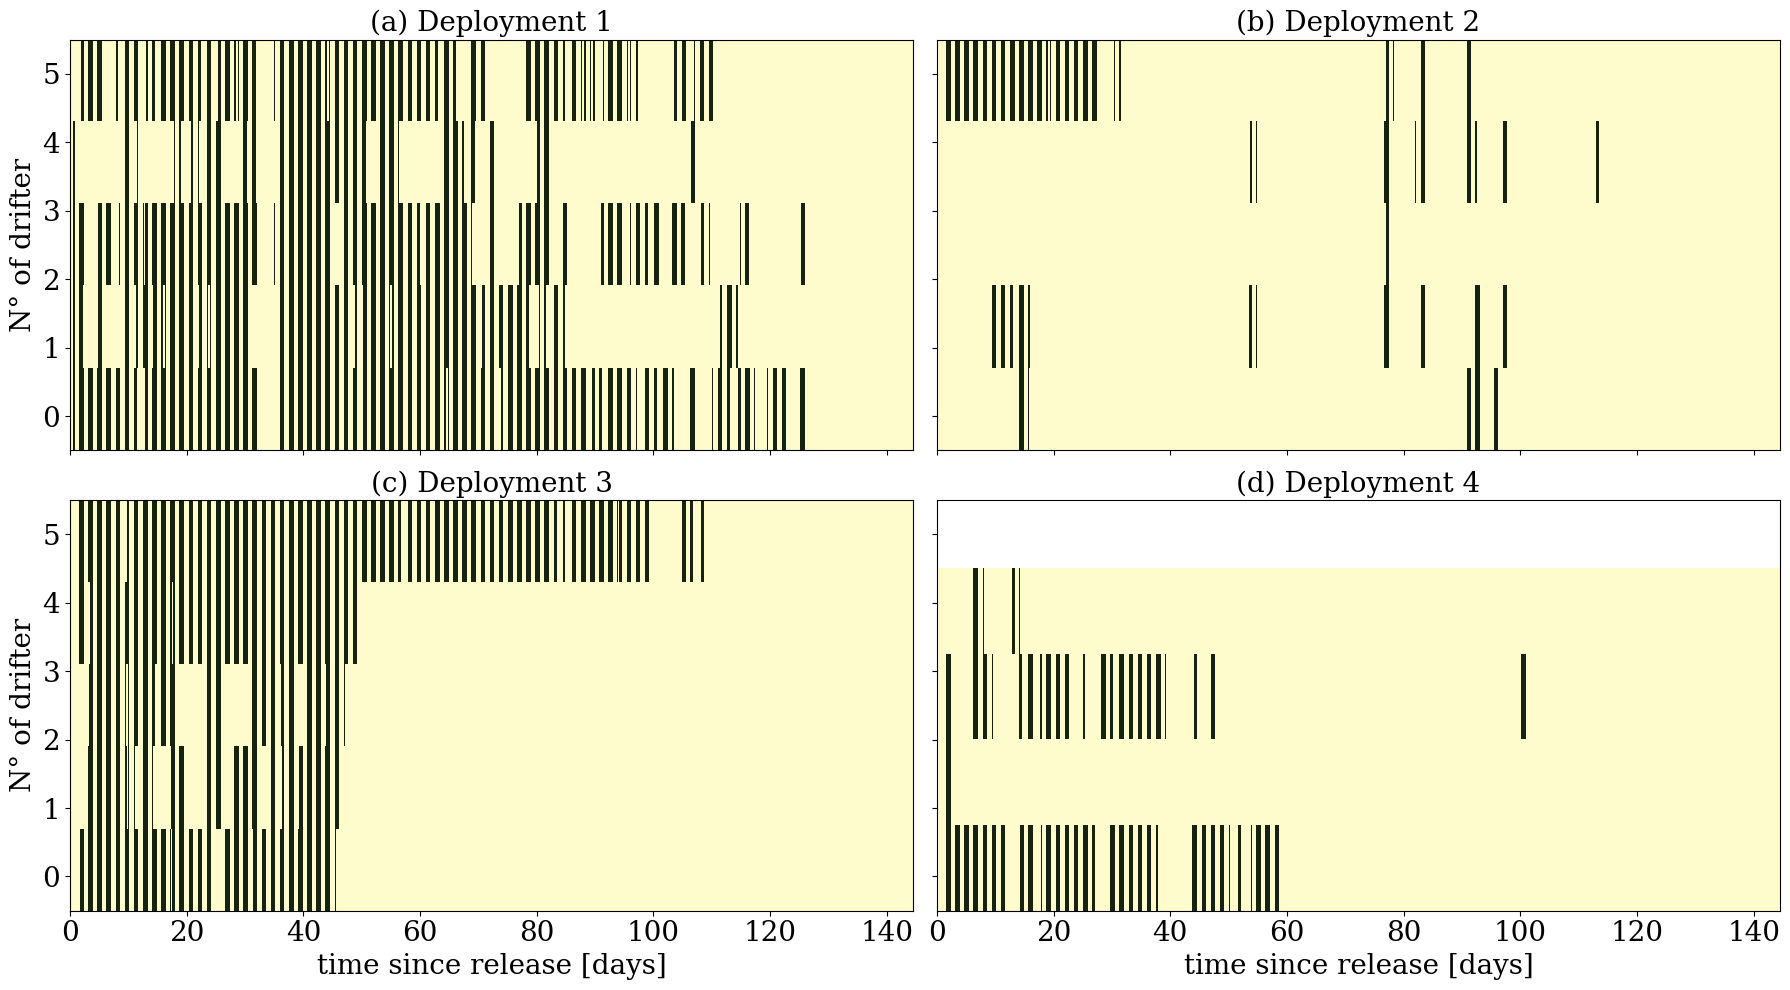

In [292]:
fig, ax = plt.subplots(2,2, sharex = True, sharey = True, figsize = (18,10))

ax[0,0].imshow(masks_time_1, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_1.shape[1]*30/1440, -0.5, masks_time_1.shape[0] + 0.5))
ax[0,1].imshow(masks_time_2, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_2.shape[1]*30/1440, -0.5, masks_time_2.shape[0] + 0.5))
ax[1,0].imshow(masks_time_3, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_3.shape[1]*30/1440, -0.5, masks_time_3.shape[0] + 0.5))
ax[1,1].imshow(masks_time_4, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_4.shape[1]*30/1440, -0.5, masks_time_4.shape[0] + 0.5))

ax[0,0].set_title('(a) Deployment 1', fontsize = 20)
ax[0,1].set_title('(b) Deployment 2', fontsize = 20)
ax[1,0].set_title('(c) Deployment 3', fontsize = 20)
ax[1,1].set_title('(d) Deployment 4', fontsize = 20)

ax[0,0].set_ylabel('N° of drifter')
ax[1,0].set_ylabel('N° of drifter')

ax[0,0].set_ylim(-0.5, masks_time_1.shape[0] + 0.5)

ax[1,0].set_xlabel('time since release [days]')
ax[1,1].set_xlabel('time since release [days]')

plt.tight_layout()
plt.show()

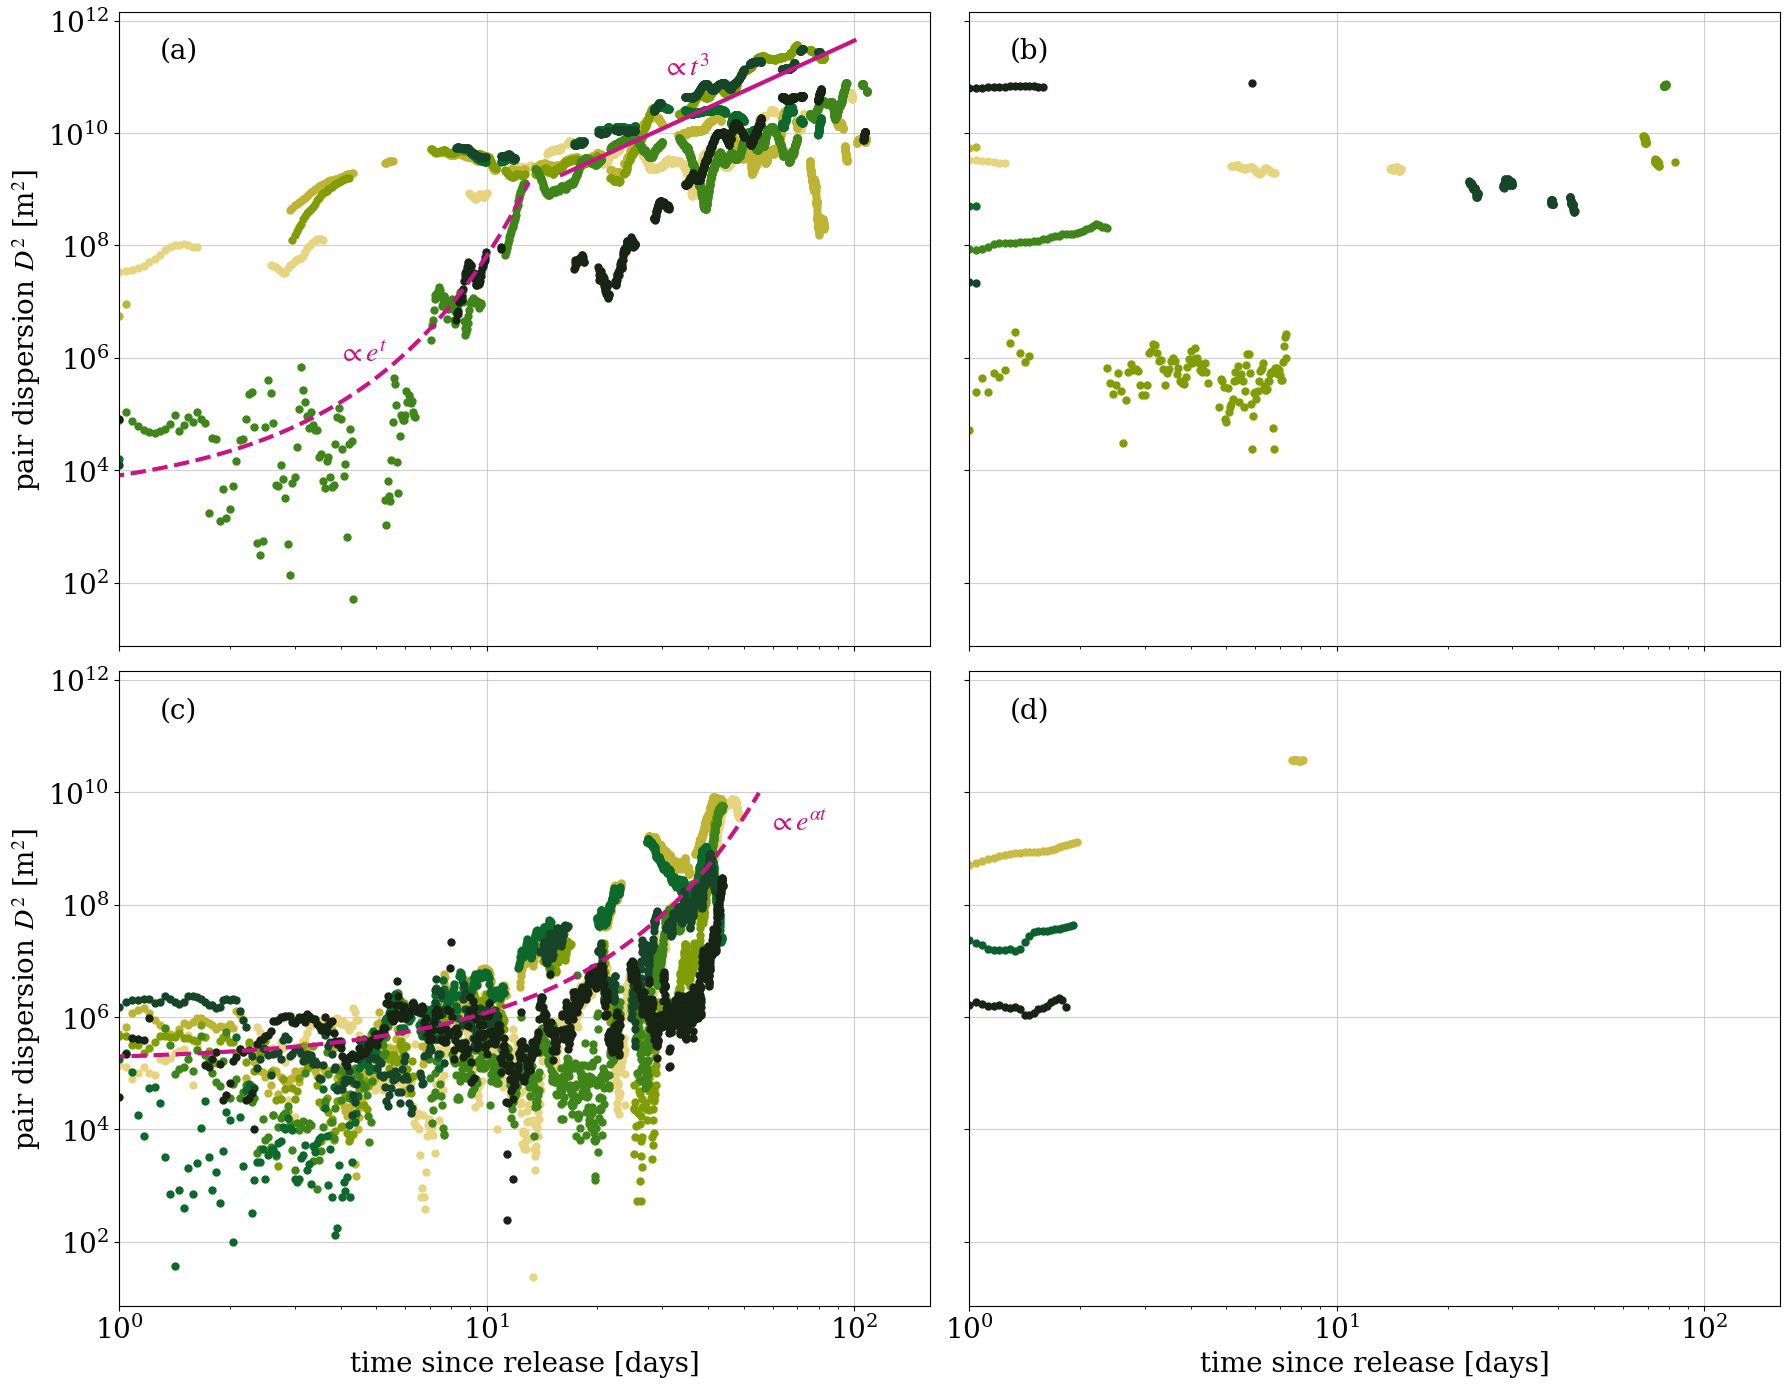

In [182]:
index_plot_D = ['(a)', '(b)', '(c)', '(d)']
index_plot_K = ['(a)', '(b)', '(c)', '(d)']

datasets = [
    (Ds_1, Ks_1, mask_pair_1, ts_1, interpolated_trajs_1),
    (Ds_2, Ks_2, mask_pair_2, ts_2, interpolated_trajs_2),
    (Ds_3, Ks_3, mask_pair_3, ts_3, interpolated_trajs_3),
    (Ds_4, Ks_4, mask_pair_4, ts_4, interpolated_trajs_4)
]

# Create first figure for pair dispersion (2x2 grid)
fig1, axes1 = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(18, 14))
axes1 = axes1.flatten()

for idx, (Ds, Ks, mask_pair, ts, interpolated_trajs) in enumerate(datasets):
    ax = axes1[idx]
    N = len(interpolated_trajs)
    N_pairs = int(N*(N-2)/2)
    
    # Pair dispersion vs time
    for i in range(N_pairs):
        try:
            t_pair = ts[mask_pair[i]]
            t_pair = t_pair[:-1].astype(int) - np.datetime64(t_pair[0]).astype(int)
            t_pair_days = t_pair/(24*60*60)
            ax.plot(t_pair_days, Ds[i]**2, c=cmap((i+1)/N_pairs), marker='o',
                   markersize=5, linestyle='', label=str(i))
        except:
            pass
    
    if idx==0:
        # First deployment
        t_exponential_1 = np.linspace(0, 13, 100)
        d_law_exponential_1 = np.exp(t_exponential_1)/np.exp(-8)
        ax.plot(t_exponential_1, d_law_exponential_1, '--', c = 'mediumvioletred', linewidth=3)

        t_richardson_1 = np.linspace(16, 100, 100)
        ax.plot(t_richardson_1, t_richardson_1**3/np.exp(-13), '-', c = 'mediumvioletred', linewidth=3)

        ax.text(0.27, 0.45, '$\propto e^t$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        ax.text(0.67, 0.90, '$\propto t^3$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')

    if idx==2:
        # Third deployment
        a_3 = 5
        t_exponential_3 = np.linspace(0, 55, 100)
        d_law_exponential_3 = np.exp(t_exponential_3/a_3)/np.exp(-12)
        ax.plot(t_exponential_3, d_law_exponential_3, '--', c = 'mediumvioletred', linewidth=3)

        # t_richardson = np.linspace(0, 100, 100)
        # ax.plot(t_richardson, t_richardson**3/np.exp(-8), '-', c = 'mediumvioletred', linewidth=2)
        # ax.plot(t_richardson, t_richardson/np.exp(-13), ':', c = 'mediumvioletred', linewidth=2)

        ax.text(0.80, 0.75, r'$\propto e^{\alpha t}$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        #ax.text(0.67, 0.90, '$\propto t^3$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
    

    # Add letter annotation in upper left corner
    ax.text(0.05, 0.96, index_plot_D[idx], transform=ax.transAxes, 
            fontsize=20, va='top', ha='left')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(alpha=0.6)
    ax.set_xlim(xmin=1)
    
    # Add labels to bottom row
    if idx >= 2:
        ax.set_xlabel('time since release [days]')
    
    # Add labels to left column
    if idx % 2 == 0:
        ax.set_ylabel('pair dispersion $D^2$ [m$^2$]')

plt.tight_layout()
plt.show()

In [275]:
np.sqrt(d_law_exponential_1[-1])

np.float64(36315.502674246636)

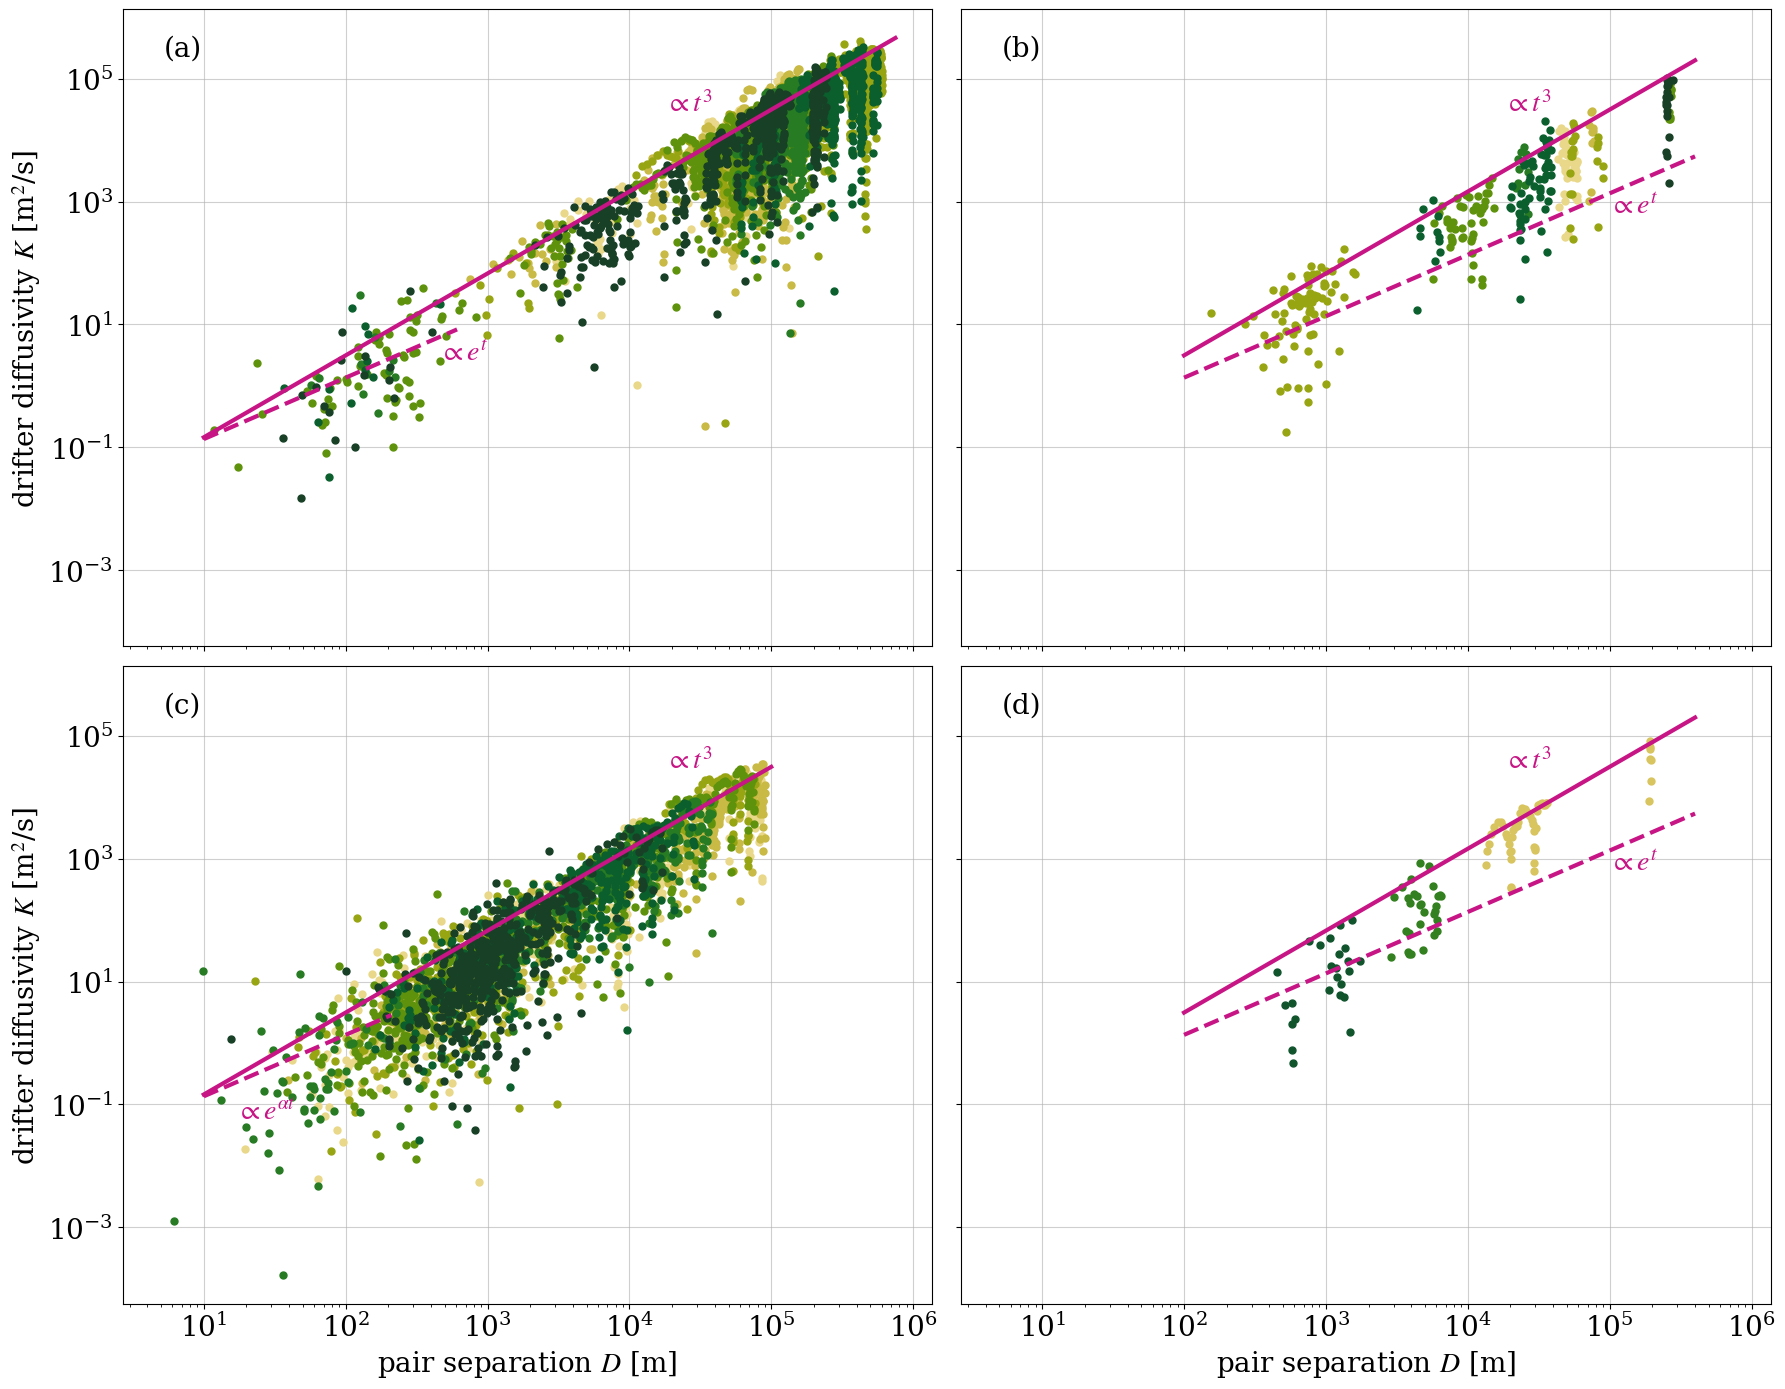

In [258]:
# Create second figure for diffusivity (2x2 grid)
fig2, axes2 = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(18, 14))
axes2 = axes2.flatten()

for idx, (Ds, Ks, mask_pair, ts, interpolated_trajs) in enumerate(datasets):
    ax = axes2[idx]
    N = len(interpolated_trajs)
    N_pairs = int(N*(N-2)/2)
    
    # Diffusivity vs pair separation
    for i in range(N_pairs):
        ax.plot(Ds[i], Ks[i], c=cmap((i+1)/(N_pairs+1)), marker='o',
               markersize=5, linestyle='', label=str(i))

    if idx==0:
        # Frist deployment
        d_k_exponential_1 = np.arange(10, np.sqrt(np.exp(t_exponential_1[-1])),100)
        ax.plot(d_k_exponential_1, d_k_exponential_1/np.exp(4.3), '--', c = 'mediumvioletred', linewidth=3)

        d_k_richardson_1 = np.arange(10, 0.75*10e5, 100)
        ax.plot(d_k_richardson_1, d_k_richardson_1**(4/3)/np.exp(5), '-', c = 'mediumvioletred', linewidth=3)

        ax.text(0.39, 0.45, '$\propto e^t$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        ax.text(0.67, 0.84, '$\propto t^3$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')

    if idx==1:
        # Second deployment
        d_k_2 = np.arange(100, 4*10e4,100)
        ax.plot(d_k_2, d_k_2/np.exp(4.3), '--', c = 'mediumvioletred', linewidth=3)

        ax.plot(d_k_2, d_k_2**(4/3)/np.exp(5), '-', c = 'mediumvioletred', linewidth=3)

        ax.text(0.8, 0.68, '$\propto e^t$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        ax.text(0.67, 0.84, '$\propto t^3$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
    
        
    if idx==2:
        # Third deployment
        d_k_exponential_3 = np.arange(10, np.sqrt(np.exp(t_exponential_3[-1]/a_3)),100)
        ax.plot(d_k_exponential_3, d_k_exponential_3/np.exp(4.3), '--', c = 'mediumvioletred', linewidth=3)

        d_k_richardson_3 = np.arange(10, 10e4, 100)
        ax.plot(d_k_richardson_3, d_k_richardson_3**(4/3)/np.exp(5), '-', c = 'mediumvioletred', linewidth=3)

        ax.text(0.14, 0.29, r'$\propto e^{ \alpha t}$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        ax.text(0.67, 0.84, '$\propto t^3$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')

    if idx==3:
        # Fourth deployment
        d_k_2 = np.arange(100, 4*10e4,100)
        ax.plot(d_k_2, d_k_2/np.exp(4.3), '--', c = 'mediumvioletred', linewidth=3)

        ax.plot(d_k_2, d_k_2**(4/3)/np.exp(5), '-', c = 'mediumvioletred', linewidth=3)

        ax.text(0.8, 0.68, '$\propto e^t$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        ax.text(0.67, 0.84, '$\propto t^3$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        
    ax.text(0.05, 0.96, index_plot_D[idx], transform=ax.transAxes, 
            fontsize=20, va='top', ha='left')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(alpha=0.6)
    
    # Add labels to bottom row
    if idx >= 2:
        ax.set_xlabel('pair separation $D$ [m]')
    
    # Add labels to left column
    if idx % 2 == 0:
        ax.set_ylabel('drifter diffusivity $K$ [m$^2$/s]')

plt.tight_layout()
plt.show()

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

### Finite-scale Lyapunov Exponent

In [101]:
def calculate_fsle(D, times, r):
    """
    Calculate FSLE (Finite-Size Lyapunov Exponent).
    
    FSLE(D) = ln(r) / τ(D)
    
    where τ(D) is the time for D to increase by factor r > 1.
    """
    D = np.array(D)
    times = np.array(times)
    
    D0 = D[0]
    D_target = D0 * r
    
    # Find first time D reaches D_target
    idx = np.where(D >= D_target)[0][0]
    tau = times[idx] - times[0]
    
    fsle = np.log(r) / tau
    
    return fsle, tau, D0, D_target

In [102]:
def calculate_fsle(D, t, r=2.0, D_bins=None):
    """
    Calculate Finite-Scale Lyapunov Exponent (FSLE).
    
    Parameters:
    -----------
    D : array-like
        Time series of pair separation distances
    t : array-like
        Time stamps corresponding to each separation measurement
    r : float
        Growth factor (default: 2.0)
    D_bins : array-like, optional
        Specific initial scales to compute FSLE at (e.g., logarithmically spaced)
    
    Returns:
    --------
    lambda_values : array
        FSLE values for each growth event
    D_initial : array
        Initial separation distances for each event
    tau_values : array
        Growth times for each event
    """
    D = np.asarray(D)
    t = np.asarray(t)
    
    if D_bins is not None:
        # Calculate FSLE at specific scales
        lambda_values = []
        D_initial = []
        tau_values = []
        
        for D0_target in D_bins:
            # Find first time D exceeds D0_target
            idx_start = np.where(D >= D0_target)[0]
            if len(idx_start) == 0:
                continue
            
            i = idx_start[0]
            D0 = D[i]
            t0 = t[i]
            target = D0 * r
            
            # Find when separation exceeds target
            idx_end = np.where(D[i:] >= target)[0]
            
            if len(idx_end) > 0:
                j = idx_end[0]
                tau = t[i + j] - t0
                
                if tau > 0:
                    lam = np.log(r) / tau
                    lambda_values.append(lam)
                    D_initial.append(D0)
                    tau_values.append(tau)
        
        return np.array(lambda_values), np.array(D_initial), np.array(tau_values)
    
    else:
        # Original algorithm: consecutive doublings
        lambda_values = []
        D_initial = []
        tau_values = []
        
        i = 0
        while i < len(D) - 1:
            D0 = D[i]
            t0 = t[i]
            target = D0 * r
            
            # Find when separation exceeds target
            idx = np.where(D[i:] >= target)[0]
            
            if len(idx) > 0:
                j = idx[0]
                tau = t[i + j] - t0
                
                if tau > 0:
                    lam = np.log(r) / tau
                    lambda_values.append(lam)
                    D_initial.append(D0)
                    tau_values.append(tau)
                    i += j
                else:
                    i += 1
            else:
                break
        
        return np.array(lambda_values), np.array(D_initial), np.array(tau_values)

In [ ]:
def calculate_fsle(D, times, r=2.0):
    """
    Calculate FSLE (Finite-Size Lyapunov Exponent) for multiple growth intervals.
    
    FSLE(D) = ln(r) / τ(D)
    
    where τ(D) is the time for D to increase by factor r > 1.
    
    Returns arrays with FSLE values for each initial separation that can grow by factor r.
    """
    D = np.array(D)
    times = np.array(times)
    
    fsle_values = []
    tau_values = []
    D0_values = []
    D_target_values = []
    
    # Calculate FSLE for each point that can grow by factor r
    for i in range(len(D)):
        D0 = D[i]
        D_target = D0 * r
        
        # Find first time after current point where D reaches D_target
        future_idx = np.where(D[i:] >= D_target)[0]
        
        if len(future_idx) > 0:
            idx = i + future_idx[0]
            tau = times[idx] - times[i]
            fsle = np.log(r) / tau
            
            fsle_values.append(fsle)
            tau_values.append(tau)
            D0_values.append(D0)
            D_target_values.append(D_target)
    
    return (np.array(fsle_values), np.array(D0_values), 
            np.array(tau_values))

In [237]:
def calculate_fsle(D, times, r=2.0, n_points=None):
    """
    Calculate FSLE (Finite-Size Lyapunov Exponent) for multiple growth intervals.
    
    FSLE(D) = ln(r) / τ(D)
    
    where τ(D) is the time for D to increase by factor r > 1.
    
    Parameters:
    -----------
    n_points : int, optional
        Number of FSLE points to calculate. If None, uses non-overlapping intervals.
    """
    D = np.array(D)
    times = np.array(times)
    
    fsle_values = []
    tau_values = []
    D0_values = []
    D_target_values = []
    
    if n_points is None:
        # Use non-overlapping intervals
        i = 0
        while i < len(D):
            D0 = D[i]
            D_target = D0 * r
            
            future_idx = np.where(D[i:] >= D_target)[0]
            
            if len(future_idx) > 0:
                idx = i + future_idx[0]
                tau = times[idx] - times[i]
                fsle = np.log(r) / tau
                
                fsle_values.append(fsle)
                tau_values.append(tau)
                D0_values.append(D0)
                D_target_values.append(D_target)
                
                i = idx  # Jump to target point
            else:
                break
    else:
        # Sample evenly spaced starting points
        indices = np.linspace(0, len(D)-1, n_points, dtype=int)
        
        for i in indices:
            D0 = D[i]
            D_target = D0 * r
            
            future_idx = np.where(D[i:] >= D_target)[0]
            
            if len(future_idx) > 0:
                idx = i + future_idx[0]
                tau = times[idx] - times[i]
                fsle = np.log(r) / tau
                
                fsle_values.append(fsle)
                tau_values.append(tau)
                D0_values.append(D0)
                D_target_values.append(D_target)
    
    return (np.array(fsle_values), np.array(D0_values))

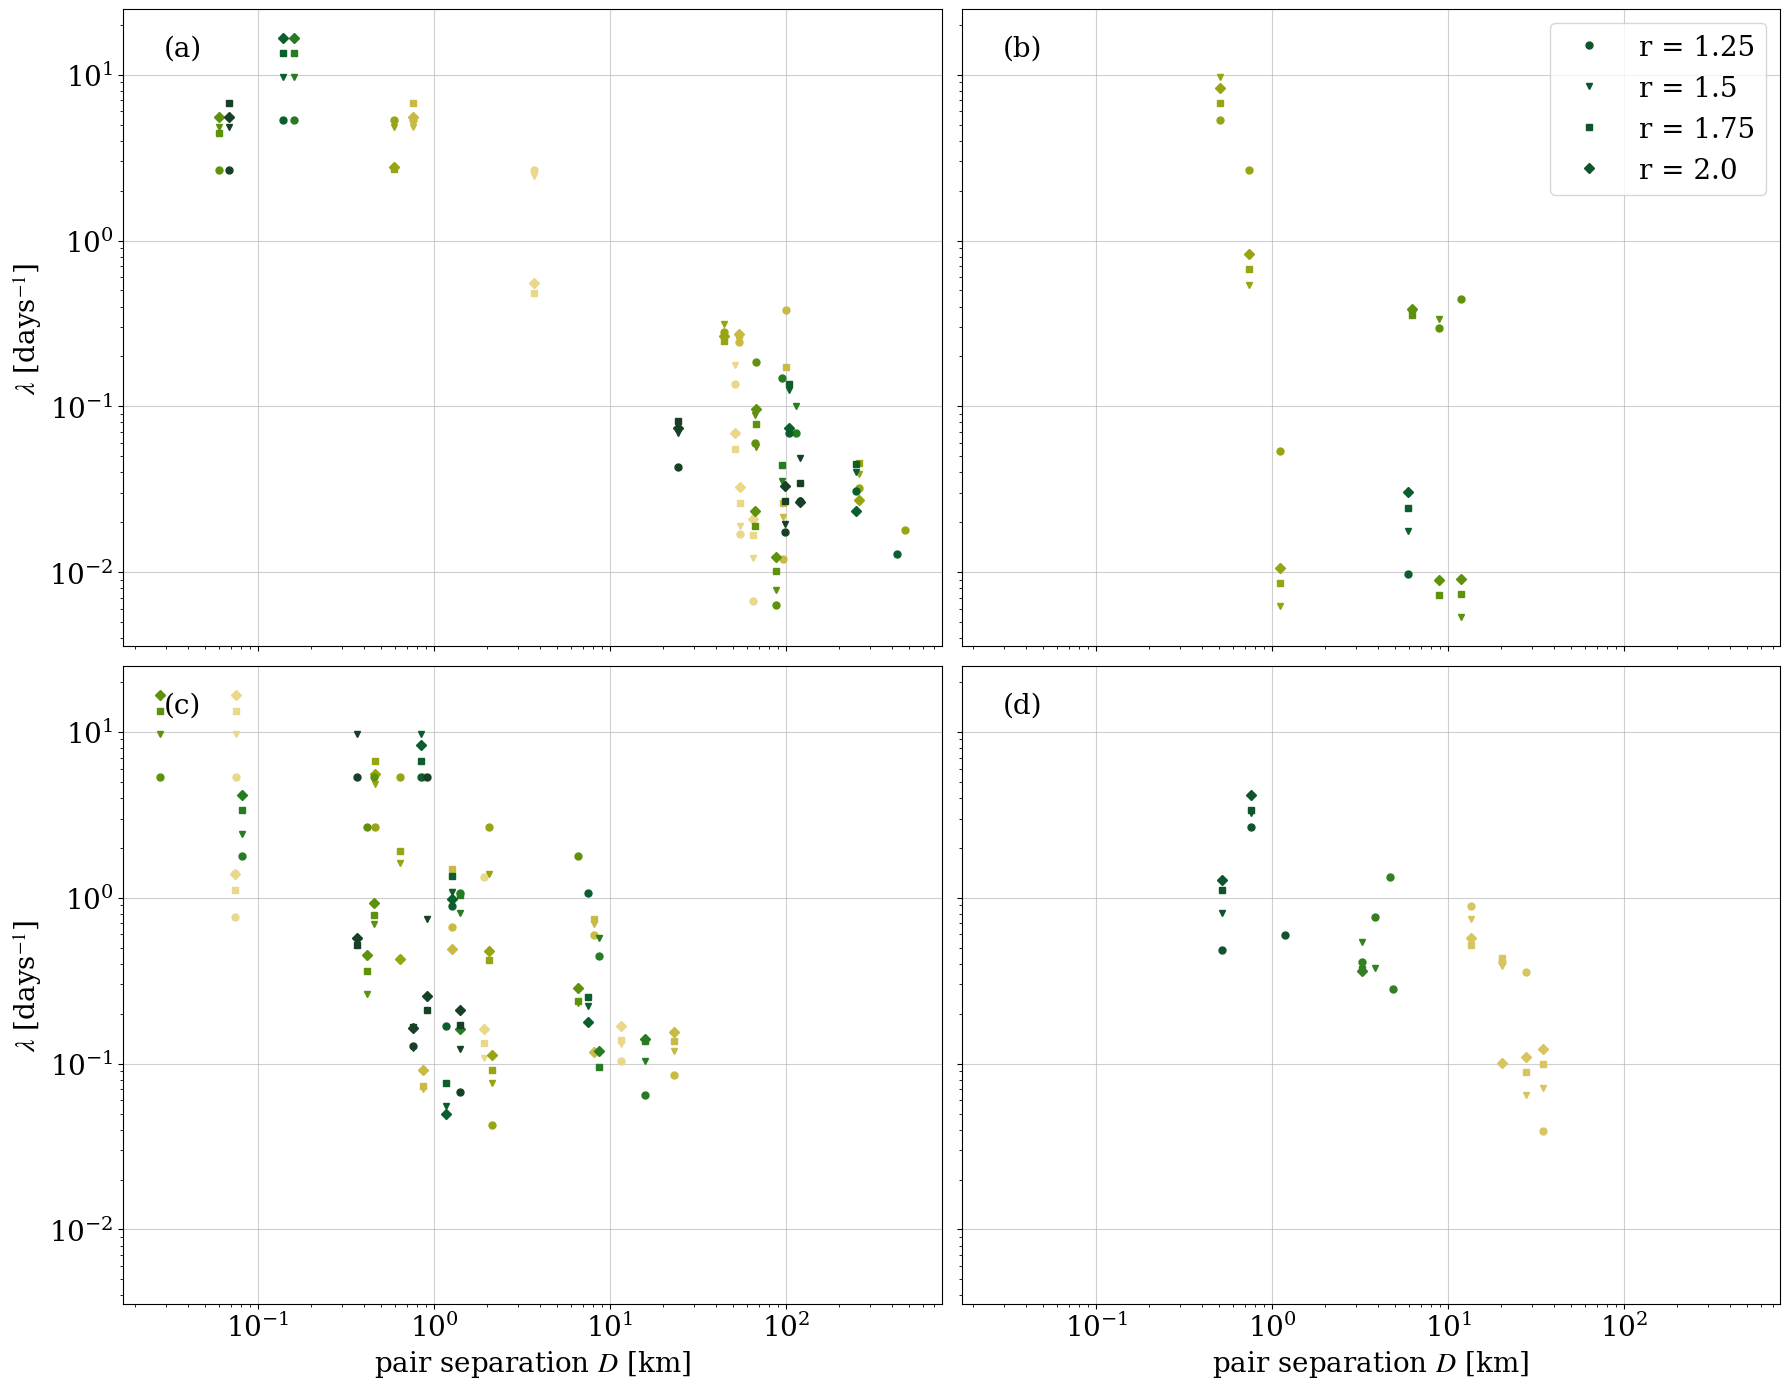

In [282]:
datasets = [
    (interpolated_trajs_1, ts_1, Ds_1, mask_pair_1),
    (interpolated_trajs_2, ts_2, Ds_2, mask_pair_2),
    (interpolated_trajs_3, ts_3, Ds_3, mask_pair_3),
    (interpolated_trajs_4, ts_4, Ds_4, mask_pair_4)
]

rs = np.arange(1.25, 2.25, 0.25)
markers = ['o', 'v', 's', 'D']
letters = ['(a)', '(b)', '(c)', '(d)']

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(18,14), sharex=True, sharey=True)
axes = axes.flatten()

# Store handles and labels for legend
handles, labels = [], []

for idx, (interpolated_trajs, ts, Ds, mask_pair) in enumerate(datasets):
    ax = axes[idx]
    N = len(interpolated_trajs)
    N_pairs = int(N*(N-2)/2)
    
    for i in range(N_pairs):
        try:
            t_pair = ts[mask_pair[i]]
            t_pair = t_pair[:-1].astype(int) - np.datetime64(t_pair[0]).astype(int)
            t_pair_days = t_pair/(24*60*60)
            D_km = Ds[i]/1000
            
            for k in range(len(rs)):
                fsle, D0 = calculate_fsle(D_km, t_pair_days, r=rs[k], n_points=5)
                
                # Collect legend items from the last dataset and last pair
                if idx == 3 and i == N_pairs-1:
                    line, = ax.plot(D0, fsle, c=cmap((i+1)/(N_pairs+1)), marker=markers[k], 
                                   markersize=5, linestyle='')
                    handles.append(line)
                    labels.append('r = ' + str(rs[k]))
                else:
                    ax.plot(D0, fsle, c=cmap((i+1)/(N_pairs+1)), marker=markers[k], 
                           markersize=5, linestyle='')
        except:
            pass
    

    # if idx==0:
    #     # Frist deployment
    #     d_k_exponential_1 = np.arange(10**(-1.2), 1000,100)
    #     ax.plot(d_k_exponential_1, d_k_exponential_1**(-1), '--', c = 'mediumvioletred', linewidth=3)

    #     d_k_richardson_1 = np.arange(10**(-1.2), 1000,100)
    #     ax.plot(d_k_richardson_1, d_k_richardson_1**(-2/3), '-', c = 'mediumvioletred', linewidth=3)

    #     #ax.text(0.39, 0.45, '$\propto e^t$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
    #     #ax.text(0.67, 0.84, '$\propto t^3$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(alpha = 0.6)
    
    # Add letter annotation in upper left corner
    ax.text(0.05, 0.96, letters[idx], transform=ax.transAxes, 
            fontsize=20, va='top', ha='left')

# Add legend to upper right subplot (idx==1) using collected handles and labels
axes[1].legend(handles, labels, loc='upper right')

axes[0].set_ylabel('$\lambda$ [days$^{-1}$]', fontsize = 20)
axes[2].set_ylabel('$\lambda$ [days$^{-1}$]', fontsize = 20)

axes[2].set_xlabel('pair separation $D$ [km]', fontsize = 20)
axes[3].set_xlabel('pair separation $D$ [km]', fontsize = 20)

# Add shared labels
#fig.text(0.5, 0.04, 'pair separation $D$ [km]', ha='center', fontsize=20)
#fig.text(0.04, 0.5, '$\lambda$ [days$^{-1}$]', va='center', rotation='vertical', fontsize=20)

plt.tight_layout()
plt.show()